In [1]:
import numpy

from finance_utils.namedtuples import *
from finance_utils.uniontypes import *
from finance_utils.asset.spot.base import Spot
# from finance_utils.asset.spot.strategy import SpotCostAveragingPlan
from finance_utils.strategy.dca import *

from finance_utils.process.prices.gbm import RVDecoupledGBM, GBM, NormalDistribution
from finance_utils.trader.base import Trader
from finance_utils.trader.utility import *

from matplotlib import pyplot

from data_utils.stochastic_utils.distributions.nonParametricDistribution import HistogramDist, KernelMixDist, SmoothHisDist
from data_utils.stochastic_utils.random_process.correlatedRandom import random_correlated_series
from easy_datetime.timestamp import TimeStamp
import tqdm

from matplotlib import pyplot

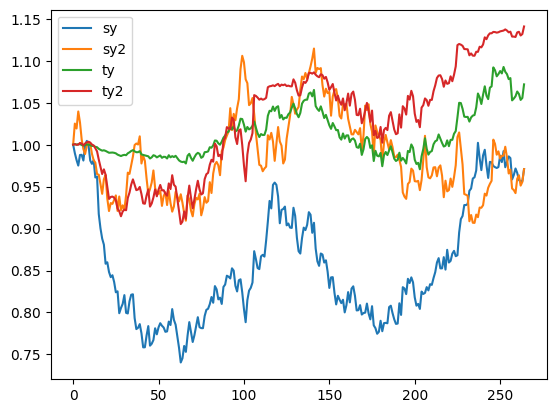

In [56]:
stock = Spot("stock", 100, TradeDelta("day", 1))
stock2 = Spot("stock2", 100, TradeDelta("day", 1))
days = 22 * 12
# process = GBM("stock", 1, 0.03 / days, 0.015, days, TimeStamp.now().accurate_to("year"), "day", 1)
trader = Trader("trader", 20000 * 12)
trader2 = Trader("trader2", 20000 * 12)

r = random_correlated_series(
    [NormalDistribution(0 / days, 0.015), NormalDistribution(0 / days, 0.015)],
    [1, -0.2],
    days,
)

process = RVDecoupledGBM(stock.name, r[0], 1, TimeStamp.now().accurate_to("year"), "day", 1)
process2 = RVDecoupledGBM(stock2.name, r[1], 0.5, TimeStamp.now().accurate_to("year"), "day", 1)

sy = []
sy2 = []
ty = []
ty2 = []
trigger_set = set(range(0, days, 22))
trigger_set2 = set(range(days))
for i, t, path in process.process_iter():
    path2 = process2[i]
    dic = {**path.dic, **path2.dic}
    _, spot_yield = simple_dca(process.s0, i, t, path, stock, trader, 10000, trigger_set)
    _, spot2_yield = simple_dca(process2.s0, i, t, path2, stock2, trader, 10000, trigger_set)
    _, _ = price_qualified_dca(process.s0, i, t, path, stock, trader2, 10000, trigger_set2, 0.99, 1.01)
    _, _ = price_qualified_dca(process2.s0, i, t, path2, stock2, trader2, 10000, trigger_set2, 0.99, 1.01)
    sy.append(spot_yield)
    sy2.append(spot2_yield)
    ty.append(trader.net_worth_rate(**dic))
    ty2.append(trader2.net_worth_rate(**dic))
    # ty2.append(trader2_yield)

pyplot.plot(sy, label="sy")
pyplot.plot(sy2, label="sy2")
pyplot.plot(ty, label="ty")
pyplot.plot(ty2, label="ty2")
pyplot.legend()
pyplot.show()